# COMP3065 Computer Vision Coursework
@author: Gaole Dai (20124917)

@email: scygd1@nottingham.edu.cn

@file: image search with ResNet18 feature extraction

@cite: code partially from https://github.com/MathMagicx/JupyterNotebooks

## Mount Drive

In [ ]:
!nvidia-smi
from google.colab import drive
drive.mount('/content/drive')

Sun May  1 14:41:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    73W / 149W |   1508MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Prerequisites

In [ ]:
import os
import pdb
import pandas as pd
import numpy as np
from numpy.testing import assert_almost_equal
import pickle
import matplotlib.pyplot as plt
from torch.autograd import Variable
from PIL import Image
import time
import copy

import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from tqdm import tqdm
from torch.utils.data import Dataset

from torchvision import transforms, models
import torch.optim as optim
from torchvision.io import read_image

if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

## Dataset Preparation

In [ ]:
import os, sys, tarfile

file_path = '/content/drive/MyDrive/y4_cv/oxbuild_images'


def extract(tar_url, extract_path='.'):
    tar = tarfile.open(tar_url, 'r')
    for item in tar:
        tar.extract(item, extract_path)
        if item.name.find(".tgz") != -1 or item.name.find(".tar") != -1:
            extract(item.name, "./" + item.name[:item.name.rfind('/')])

extract(file_path + '.tgz', '/content/drive/MyDrive/y4_cv/oxbuild_images')
    

## Rescale the Image



In [ ]:
inputDim = (224, 224)
input_path = '/content/drive/MyDrive/y4_cv/oxbuild_images_400'
output_path = '/content/drive/MyDrive/y4_cv/oxbuild_images_400_new'

os.makedirs(output_path, exist_ok = True)

img_transformation = transforms.Compose([transforms.Resize(inputDim)])

for image_name in os.listdir(input_path):
    img = Image.open(os.path.join(input_path, image_name))
    new_img = img_transformation(img)

    # # copy the rotation information metadata from original image and save, else your transformed images may be rotated
    # exif = img.info['exif']
    new_img.save(os.path.join(output_path, image_name))
    
    new_img.close()
    img.close()

## DataLoader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


429
Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


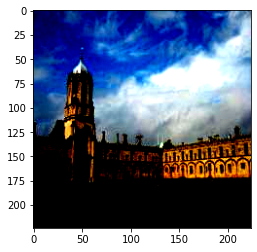

Label: 4


In [ ]:
labels_map = {
    0: "all-souls",
    1: "ashmolean",
    2: "balliol",
    3: "bodleian",
    4: "christ church",
    5: "cornmarket",
    6: "hertford",
    7: "keble",
    8: "magdalen",
    9: "pitt rivers",
    10: "radcliffe camera"
}

class OxfordBuilding(Dataset):
    def __init__(self, transform=None, target_transform=None):
        self.img_labels = pd.read_csv('/content/drive/MyDrive/y4_cv/labels-training.csv')
        self.img_dir = '/content/drive/MyDrive/y4_cv/oxbuild_images_400_new'
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize([0.4811, 0.4843, 0.4689], [0.2740, 0.2794, 0.3138])
])

oxford5k_dataset = OxfordBuilding(transform=transform)
test_split = .1
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and test splits:
dataset_size = len(oxford5k_dataset)
dataset_classes = 11
indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]
print(dataset_size)

# Creating PT data samplers and loaders:
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
test_sampler = torch.utils.data.sampler.SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(oxford5k_dataset, batch_size=32, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(oxford5k_dataset, batch_size=16, sampler=test_sampler)

"""
# Calculate the std and mean
def batch_mean_and_sd(loader):
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, _ in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2, dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)
        cnt += nb_pixels

    mean, std = fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)        
    return mean,std
  
mean, std = batch_mean_and_sd(train_loader)
print("mean and std: \n", mean, std)
# """

train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
img = img.swapaxes(0,1)
img = img.swapaxes(1,2)
plt.imshow(img)
plt.show()
print(f"Label: {label}")

## Fine-tuning Model

In [ ]:
def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=100):
    since = time.time()

    best_model = model
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        optimizer = lr_scheduler(optimizer, epoch)
        model.train()  # Set model to training mode

        running_loss = 0.0
        running_corrects = 0

        counter=0
        # Iterate over data.
        for data in train_loader:
            inputs, labels = data
            print(inputs.size())
            # wrap them in Variable
            if device == 'cuda':
              inputs, labels = inputs.to(device), labels.to(device),                       

            # Set gradient to zero to delete history of computations in previous epoch. Track operations so that differentiation can be done automatically.
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            
            loss = criterion(outputs, labels)
            # print('loss done')                
            # Just so that you can keep track that something's happening and don't feel like the program isn't running.
            # if counter%10==0:
            #     print("Reached iteration ",counter)
            counter+=1

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)

            print('trying epoch loss {}'.format(epoch))
            epoch_loss = running_loss / len(train_indices)
            epoch_acc = running_corrects.item() / float(len(train_indices))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                'train', epoch_loss, epoch_acc))
        
        running_loss = 0.0
        running_corrects = 0    
        for data in test_loader:
          inputs, labels = data
          print(inputs.size())
          # wrap them in Variable
          if device == 'cuda':
            inputs, labels = inputs.to(device), labels.to(device)
          # Set gradient to zero to delete history of computations in previous epoch. Track operations so that differentiation can be done automatically.
          optimizer.zero_grad()
          outputs = model(inputs)
          _, preds = torch.max(outputs.data, 1)
          
          loss = criterion(outputs, labels)
          counter+=1             
          print('trying epoch loss')

          running_loss += loss.item()
          running_corrects += torch.sum(preds == labels.data)

          epoch_loss = running_loss / len(test_indices)
          epoch_acc = running_corrects.item() / len(test_indices)

          print('{} Loss: {:.4f} Acc: {:.4f}'.format(
              'test', epoch_loss, epoch_acc))
          if epoch_acc > best_acc:
              best_acc = epoch_acc
              best_model = copy.deepcopy(model)
              print('new best accuracy = ',best_acc)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('returning and looping back')
    return best_model

BASE_LR = 0.001
EPOCH_DECAY = 30
DECAY_WEIGHT = 0.1
def exp_lr_scheduler(optimizer, epoch, init_lr=BASE_LR, lr_decay_epoch=EPOCH_DECAY):
    """Decay learning rate by a factor of DECAY_WEIGHT every lr_decay_epoch epochs."""
    lr = init_lr * (DECAY_WEIGHT**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, dataset_classes)

criterion = nn.CrossEntropyLoss()

if device == 'cuda':
    criterion.cuda()
    model_ft.cuda()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Run the functions and save the best model in the function model_ft.
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=60)

# Save model
torch.save(model_ft.state_dict(), '/content/drive/MyDrive/y4_cv/fine_tuned_best_model_400.pth')


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch 0/59
----------
LR is set to 0.001
torch.Size([32, 3, 224, 224])
trying epoch loss 0
train Loss: 0.0076 Acc: 0.0000
torch.Size([32, 3, 224, 224])
trying epoch loss 0
train Loss: 0.0113 Acc: 0.0439
torch.Size([32, 3, 224, 224])
trying epoch loss 0
train Loss: 0.0128 Acc: 0.1163
torch.Size([32, 3, 224, 224])
trying epoch loss 0
train Loss: 0.0142 Acc: 0.1835
torch.Size([32, 3, 224, 224])
trying epoch loss 0
train Loss: 0.0155 Acc: 0.2558
torch.Size([32, 3, 224, 224])
trying epoch loss 0
train Loss: 0.0176 Acc: 0.3178
torch.Size([32, 3, 224, 224])
trying epoch loss 0
train Loss: 0.0185 Acc: 0.3876
torch.Size([32, 3, 224, 224])
trying epoch loss 0
train Loss: 0.0192 Acc: 0.4651
torch.Size([32, 3, 224, 224])
trying epoch loss 0
train Loss: 0.0207 Acc: 0.5401
torch.Size([32, 3, 224, 224])
trying epoch loss 0
train Loss: 0.0220 Acc: 0.6124
torch.Size([32, 3, 224, 224])
trying epoch loss 0
train Loss: 0.0231 Acc: 0.6848
torch.Size([32, 3, 224, 224])
trying epoch loss 0
train Loss: 0.0258

## Feature Extraction

In [ ]:
class img2VectorResnet18():
    def __init__(self):
        if device == 'cuda':
          self.device = torch.device("cuda")
        else:
          self.device = torch.device("cpu")
        self.features_number = 512
        self.model, self.featureLayer = self.get_feature_layer()
        self.model = self.model.to(self.device)
        self.model.eval()
        self.toTensor = transforms.ToTensor()

    def get_feature_vector(self, img):
        image = self.toTensor(img).unsqueeze(0).to(self.device)
        embedding = torch.zeros(1, self.features_number, 1, 1)

        def copyData(m, i, o): embedding.copy_(o.data)

        h = self.featureLayer.register_forward_hook(copyData)
        self.model(image)
        h.remove()

        return embedding.numpy()[0, :, 0, 0]

    def get_feature_layer(self):
      model_ft = models.resnet18(pretrained=False)
      num_ftrs = model_ft.fc.in_features
      model_ft.fc = nn.Linear(num_ftrs, dataset_classes)

      if device == 'cuda':
          model_ft.cuda()

      model_ft.load_state_dict(torch.load('/content/drive/MyDrive/y4_cv/fine_tuned_best_model_400.pth'))
      model_ft.eval()
      layer = model_ft._modules.get('avgpool')
      self.layer_output_size = 512
      
      return model_ft, layer
        

# generate vectors for all the images in the set
img_vectors = img2VectorResnet18() 

all_vectors = {}
print("Converting images to feature vectors:")
for image in tqdm(os.listdir('/content/drive/MyDrive/y4_cv/oxbuild_images_100_new')):
    img = Image.open(os.path.join('/content/drive/MyDrive/y4_cv/oxbuild_images_100_new', image))
    vec = img_vectors.get_feature_vector(img)
    all_vectors[image] = vec
    img.close()

Converting images to feature vectors:


100%|██████████| 189/189 [00:03<00:00, 57.49it/s]


## Similar Image Matrix

In [ ]:
def get_similarity_matrix(vectors):
    v = np.array(list(vectors.values())).T
    sim = np.inner(v.T, v.T) / ((np.linalg.norm(v, axis=0).reshape(-1,1)) * ((np.linalg.norm(v, axis=0).reshape(-1,1)).T))
    keys = list(vectors.keys())
    matrix = pd.DataFrame(sim, columns = keys, index = keys)
    return matrix
        
similarity_matrix = get_similarity_matrix(all_vectors)

# the number of top similar images to be stored
k = 5
similar_names = pd.DataFrame(index = similarity_matrix.index, columns = range(k))
similar_values = pd.DataFrame(index = similarity_matrix.index, columns = range(k))

for j in tqdm(range(similarity_matrix.shape[0])):
  k_similar = similarity_matrix.iloc[j, :].sort_values(ascending = False).head(k)
  similar_names.iloc[j, :] = list(k_similar.index)
  similar_values.iloc[j, :] = k_similar.values
    
similar_names.to_pickle('/content/drive/MyDrive/y4_cv/similar_names_400.pkl')
similar_values.to_pickle('/content/drive/MyDrive/y4_cv/similar_values_400.pkl')

100%|██████████| 189/189 [00:00<00:00, 1577.84it/s]


## Plot the Results

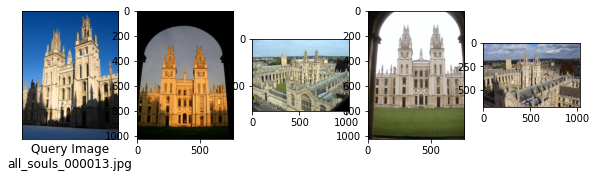

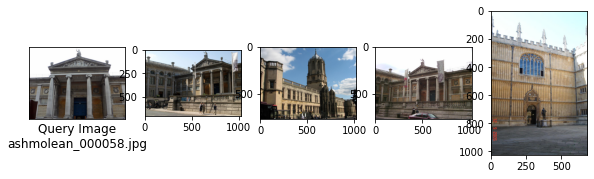

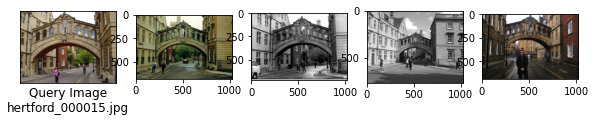

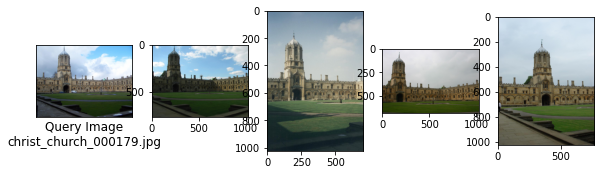

In [ ]:
inputImages = ["all_souls_000013.jpg", "ashmolean_000058.jpg", "hertford_000015.jpg", "christ_church_000179.jpg"]

numCol = 5
numRow = 1

def setAxes(ax, image, query = False, **kwargs):
    value = kwargs.get("value", None)
    if query:
        ax.set_xlabel("Query Image\n{0}".format(image), fontsize = 12)
    else:
        ax.set_xlabel("Similarity value {1:1.3f}\n{0}".format(image, value), fontsize = 12)
    ax.set_xticks([])
    ax.set_yticks([])
    
def get_similar_images(image, simNames, simVals):
    if image in set(simNames.index):
      imgs = list(simNames.loc[image, :])
      vals = list(simVals.loc[image, :])
      if image in imgs:
        assert_almost_equal(max(vals), 1, decimal = 5)
        imgs.remove(image)
        vals.remove(max(vals))
      return imgs, vals
    else:
      print("'{}' Unknown image".format(image))
        
def plot_similar_images(image, simiar_names, similar_values):
    simImages, simValues = get_similar_images(image, similar_names, similar_values)
    fig = plt.figure(figsize=(10, 20))

    for j in range(0, numCol*numRow):
      ax = []
      if j == 0:
        img = Image.open(os.path.join('/content/drive/MyDrive/y4_cv/oxbuild_images_100', image))
        ax = fig.add_subplot(numRow, numCol, 1)
        setAxes(ax, image, query = True)
      else:
        img = Image.open(os.path.join('/content/drive/MyDrive/y4_cv/oxbuild_images_100', simImages[j-1]))
        ax.append(fig.add_subplot(numRow, numCol, j+1))
        img = img.convert('RGB')
      plt.imshow(img)
      img.close()
    plt.show()   

for image in inputImages:
    plot_similar_images(image, similar_names, similar_values)